In [76]:
# Steps for Cardiac Segmentation

In [78]:
# Step 1 Libraries Import
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms as T


In [81]:
# step2  Load dataet
def load_acdc_data(data_path):
    images, masks = [], []
    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))
    images.sort()
    masks.sort()
    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")
    return images, masks

train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)


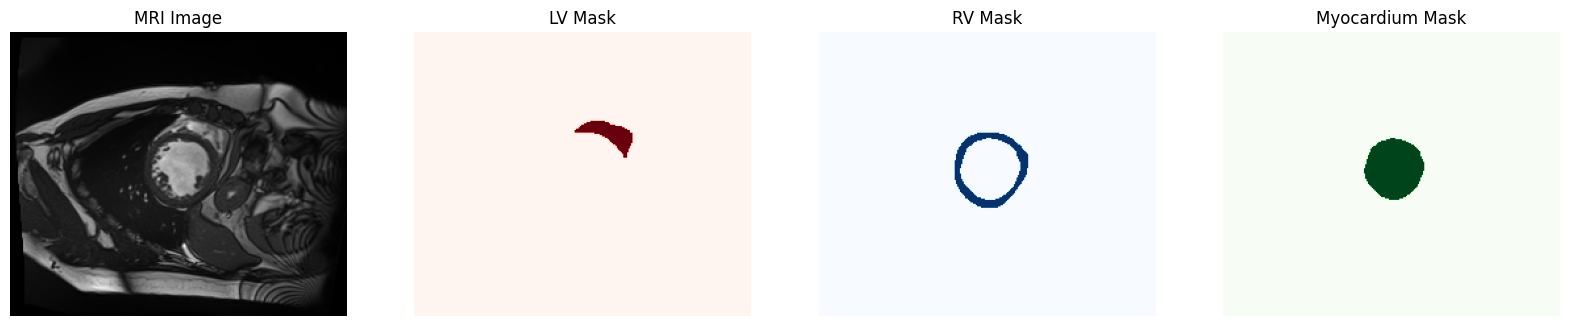

In [83]:
# step3: Visualaize dataset
def visualize_sample(image_path, mask_path):
    image = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    middle_slice = image.shape[2] // 2
    lv_mask = (mask[:, :, middle_slice] == 1).astype(float)
    rv_mask = (mask[:, :, middle_slice] == 2).astype(float)
    myo_mask = (mask[:, :, middle_slice] == 3).astype(float)
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(lv_mask, cmap="Reds")
    plt.title("LV Mask")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(rv_mask, cmap="Blues")
    plt.title("RV Mask")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.imshow(myo_mask, cmap="Greens")
    plt.title("Myocardium Mask")
    plt.axis("off")
    plt.show()

visualize_sample(train_images[0], train_masks[0])


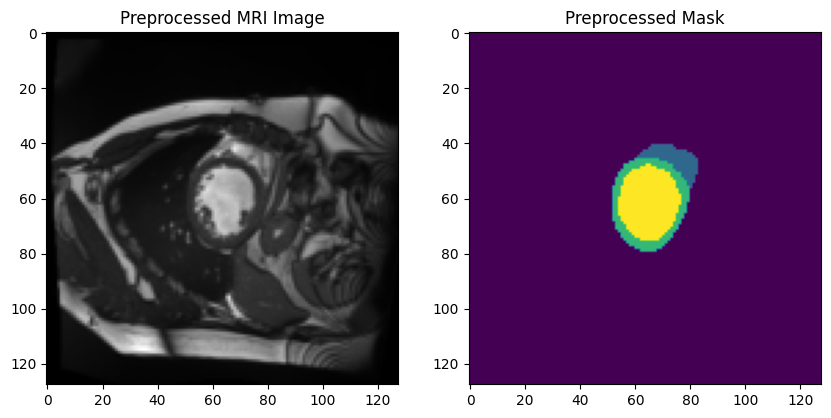

In [84]:
# STEP 4 PREPROCESSED DATA 
def preprocess_data(image_path, mask_path, target_size=(128, 128)):
    image = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    middle_slice = image.shape[2] // 2
    image_slice = image[:, :, middle_slice]
    mask_slice = mask[:, :, middle_slice]
    image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())
    image_resized = T.functional.resize(torch.tensor(image_slice).unsqueeze(0), target_size)
    mask_resized = T.functional.resize(torch.tensor(mask_slice).unsqueeze(0), target_size, interpolation=T.InterpolationMode.NEAREST)
    return image_resized.squeeze(0).numpy(), mask_resized.squeeze(0).numpy()

preprocessed_image, preprocessed_mask = preprocess_data(train_images[0], train_masks[0])

# Visualize preprocessed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image, cmap="gray")
plt.title("Preprocessed MRI Image")
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_mask, cmap="viridis")
plt.title("Preprocessed Mask")
plt.show()


In [87]:
# step 5 dataset and daataloader
class CardiacDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=(128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image, mask = preprocess_data(self.image_paths[idx], self.mask_paths[idx], self.target_size)
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask, dtype=torch.long)
        return image_tensor, mask_tensor

train_dataset = CardiacDataset(train_images, train_masks)
test_dataset = CardiacDataset(test_images, test_masks)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [90]:
# Step 6 UNET
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()
        
        # Define a convolutional block
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        # Final output layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # (B, 64, H, W)
        p1 = self.pool1(e1)  # (B, 64, H/2, W/2)

        e2 = self.enc2(p1)  # (B, 128, H/2, W/2)
        p2 = self.pool2(e2)  # (B, 128, H/4, W/4)

        e3 = self.enc3(p2)  # (B, 256, H/4, W/4)
        p3 = self.pool3(e3)  # (B, 256, H/8, W/8)

        e4 = self.enc4(p3)  # (B, 512, H/8, W/8)
        p4 = self.pool4(e4)  # (B, 512, H/16, W/16)

        # Bottleneck
        b = self.bottleneck(p4)  # (B, 1024, H/16, W/16)

        # Decoder with skip connections
        up4 = self.up4(b)  # (B, 512, H/8, W/8)
        merge4 = torch.cat([up4, e4], dim=1)  # Concatenate skip connection
        d4 = self.dec4(merge4)  # (B, 512, H/8, W/8)

        up3 = self.up3(d4)  # (B, 256, H/4, W/4)
        merge3 = torch.cat([up3, e3], dim=1)
        d3 = self.dec3(merge3)  # (B, 256, H/4, W/4)

        up2 = self.up2(d3)  # (B, 128, H/2, W/2)
        merge2 = torch.cat([up2, e2], dim=1)
        d2 = self.dec2(merge2)  # (B, 128, H/2, W/2)

        up1 = self.up1(d2)  # (B, 64, H, W)
        merge1 = torch.cat([up1, e1], dim=1)
        d1 = self.dec1(merge1)  # (B, 64, H, W)

        # Final layer
        output = self.final(d1)  # (B, out_channels, H, W)
        return output

# Instantiate the model
model = UNet(in_channels=1, out_channels=4)  # 1 input channel, 4 output channels (LV, RV, Myocardium, Background)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [91]:
# sTEP 7 mODEL tRANING
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Function to calculate Dice Score
def dice_score(pred, target, num_classes=4, epsilon=1e-6):
    dice_scores = []
    pred_one_hot = F.one_hot(pred, num_classes=num_classes).permute(0, 3, 1, 2)  # Convert to one-hot encoding
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2)
    for cls in range(num_classes):
        intersection = (pred_one_hot[:, cls] * target_one_hot[:, cls]).sum()
        union = pred_one_hot[:, cls].sum() + target_one_hot[:, cls].sum()
        dice = (2 * intersection + epsilon) / (union + epsilon)
        dice_scores.append(dice.item())
    return dice_scores

# Training loop
epochs = 20
train_losses = []
val_losses = []
val_dice_scores = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)  # Shape: (B, num_classes, H, W)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    dice_scores = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate Dice Scores
            preds = torch.argmax(outputs, dim=1)
            dice_scores.append(dice_score(preds, masks))

    # Calculate average validation loss and Dice Score
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    avg_dice_scores = np.mean(dice_scores, axis=0)  # Class-wise average Dice Score
    val_dice_scores.append(avg_dice_scores)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice Scores: {avg_dice_scores}")

# Save the model
torch.save(model.state_dict(), "unet_cardiac_segmentation.pth")


Validation: 100%|██████████| 13/13 [01:17<00:00,  5.95s/it]


Epoch 1: Train Loss: 1.1421, Val Loss: 0.4706, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:13<00:00,  5.65s/it]


Epoch 2: Train Loss: 0.3153, Val Loss: 0.2656, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:12<00:00,  5.56s/it]


Epoch 3: Train Loss: 0.2277, Val Loss: 0.2065, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:12<00:00,  5.56s/it]


Epoch 4: Train Loss: 0.1551, Val Loss: 0.1401, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:13<00:00,  5.64s/it]


Epoch 5: Train Loss: 0.1149, Val Loss: 0.1278, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.52s/it]


Epoch 6: Train Loss: 0.1105, Val Loss: 0.1205, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.52s/it]


Epoch 7: Train Loss: 0.1040, Val Loss: 0.1229, Dice Scores: [9.77665259e-01 7.03589682e-10 5.76095494e-10 5.44169987e-10]


Validation: 100%|██████████| 13/13 [01:12<00:00,  5.56s/it]


Epoch 8: Train Loss: 0.0984, Val Loss: 0.1055, Dice Scores: [9.84193155e-01 7.03589682e-10 7.75778576e-03 6.09544009e-01]


Validation: 100%|██████████| 13/13 [01:13<00:00,  5.63s/it]


Epoch 9: Train Loss: 0.0899, Val Loss: 0.0972, Dice Scores: [9.86066910e-01 7.03589682e-10 2.51911578e-01 6.17888096e-01]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.53s/it]


Epoch 10: Train Loss: 0.0826, Val Loss: 0.0969, Dice Scores: [0.98663796 0.04495935 0.33669012 0.6153347 ]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.50s/it]


Epoch 11: Train Loss: 0.0800, Val Loss: 0.1015, Dice Scores: [0.9864538  0.13971933 0.26983972 0.60547522]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.53s/it]


Epoch 12: Train Loss: 0.0795, Val Loss: 0.0954, Dice Scores: [0.98760046 0.19496305 0.4220045  0.6266691 ]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.51s/it]


Epoch 13: Train Loss: 0.0781, Val Loss: 0.0961, Dice Scores: [0.98746025 0.21111273 0.31110542 0.62546933]


Validation: 100%|██████████| 13/13 [01:10<00:00,  5.45s/it]


Epoch 14: Train Loss: 0.0815, Val Loss: 0.0901, Dice Scores: [0.98807819 0.23287608 0.27046368 0.6423932 ]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.53s/it]


Epoch 15: Train Loss: 0.0737, Val Loss: 0.0911, Dice Scores: [0.9878523  0.3307093  0.34210849 0.62030214]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.48s/it]


Epoch 16: Train Loss: 0.0758, Val Loss: 0.0891, Dice Scores: [0.98827528 0.39993109 0.25761721 0.63121294]


Validation: 100%|██████████| 13/13 [01:11<00:00,  5.50s/it]


Epoch 17: Train Loss: 0.0723, Val Loss: 0.0950, Dice Scores: [0.98815818 0.328478   0.31464656 0.62562423]


Validation: 100%|██████████| 13/13 [01:12<00:00,  5.58s/it]


Epoch 18: Train Loss: 0.0740, Val Loss: 0.0908, Dice Scores: [0.98818568 0.29231533 0.39570722 0.64212895]


Validation: 100%|██████████| 13/13 [01:10<00:00,  5.42s/it]


Epoch 19: Train Loss: 0.0703, Val Loss: 0.0905, Dice Scores: [0.98900604 0.34643198 0.3762749  0.64906437]


Validation: 100%|██████████| 13/13 [01:26<00:00,  6.69s/it]


Epoch 20: Train Loss: 0.0689, Val Loss: 0.0832, Dice Scores: [0.98942167 0.32013275 0.32952586 0.68209348]


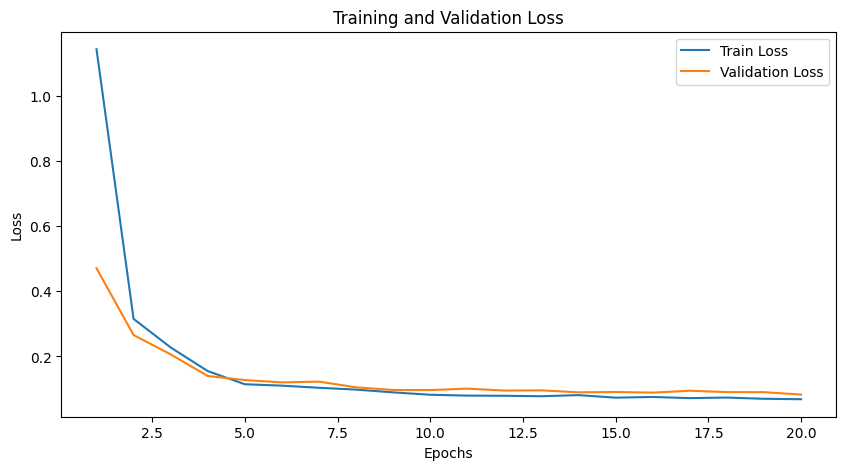

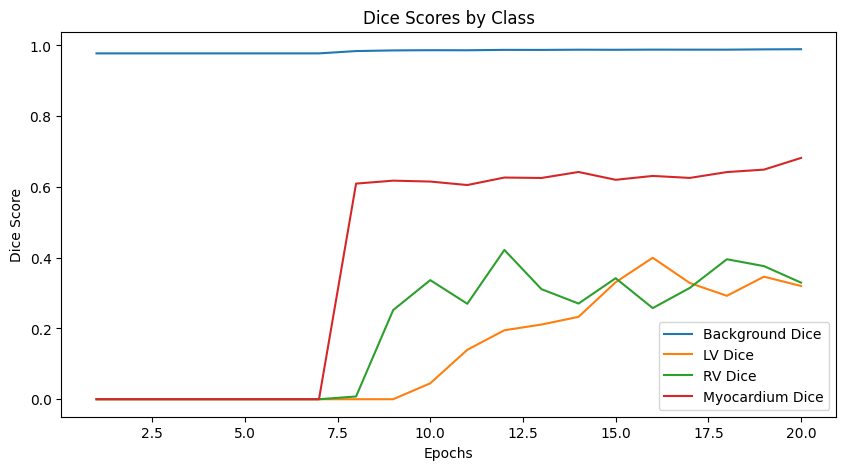

In [92]:
# Step 8 Plot Losses Code for Metrics Visualization

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Dice Scores
val_dice_scores = np.array(val_dice_scores)  # Convert to NumPy for easier slicing
classes = ["Background", "LV", "RV", "Myocardium"]

plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    plt.plot(range(1, epochs + 1), val_dice_scores[:, i], label=f"{cls} Dice")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.title("Dice Scores by Class")
plt.legend()
plt.show()


In [93]:
# Step 9 Code for Testing and Metrics Calculation
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Function to compute additional metrics: IoU, Precision, Recall, F1 Score
def compute_metrics(preds, targets, num_classes=4):
    preds_one_hot = F.one_hot(preds, num_classes=num_classes).permute(0, 3, 1, 2)
    targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)

    metrics = {"IoU": [], "Precision": [], "Recall": [], "F1-Score": []}

    for cls in range(num_classes):
        pred_cls = preds_one_hot[:, cls].flatten().cpu().numpy()
        target_cls = targets_one_hot[:, cls].flatten().cpu().numpy()

        intersection = np.sum(pred_cls * target_cls)
        union = np.sum(pred_cls) + np.sum(target_cls) - intersection

        iou = intersection / (union + 1e-6)
        precision = precision_score(target_cls, pred_cls)
        recall = recall_score(target_cls, pred_cls)
        f1 = f1_score(target_cls, pred_cls)

        metrics["IoU"].append(iou)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)

    return metrics

# Evaluate the model on the test set
model.eval()
all_metrics = {"IoU": [], "Precision": [], "Recall": [], "F1-Score": []}

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        metrics = compute_metrics(preds, masks)

        for key in all_metrics:
            all_metrics[key].append(metrics[key])

# Average metrics across all batches
avg_metrics = {key: np.mean(all_metrics[key], axis=0) for key in all_metrics}

# Print results
classes = ["Background", "LV", "RV", "Myocardium"]
for i, cls in enumerate(classes):
    print(f"\nClass: {cls}")
    print(f"IoU: {avg_metrics['IoU'][i]:.4f}")
    print(f"Precision: {avg_metrics['Precision'][i]:.4f}")
    print(f"Recall: {avg_metrics['Recall'][i]:.4f}")
    print(f"F1-Score: {avg_metrics['F1-Score'][i]:.4f}")




Testing: 100%|██████████| 13/13 [01:57<00:00,  9.06s/it]


Class: Background
IoU: 0.9791
Precision: 0.9822
Recall: 0.9967
F1-Score: 0.9894

Class: LV
IoU: 0.1951
Precision: 0.5167
Recall: 0.2385
F1-Score: 0.3201

Class: RV
IoU: 0.2002
Precision: 0.6298
Recall: 0.2255
F1-Score: 0.3295

Class: Myocardium
IoU: 0.5276
Precision: 0.6385
Recall: 0.7557
F1-Score: 0.6821


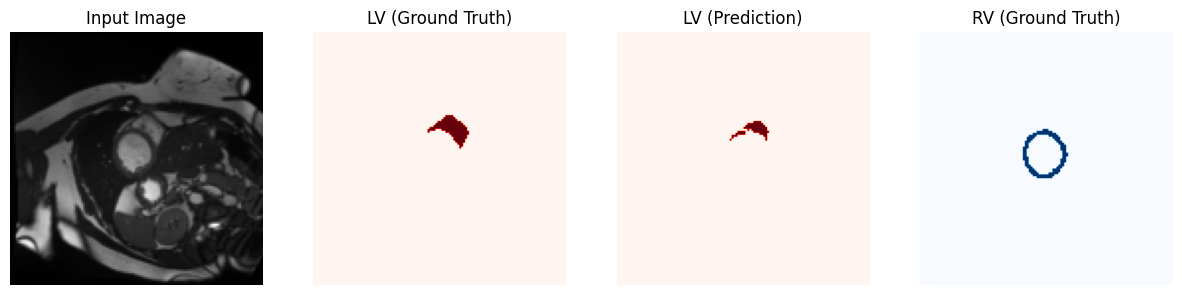

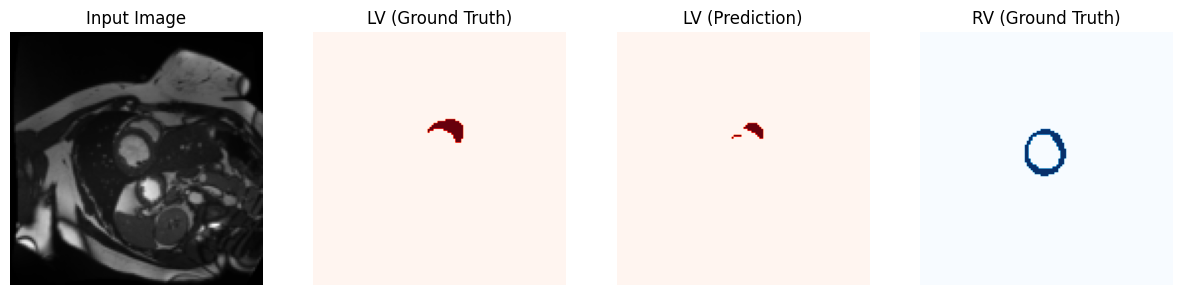

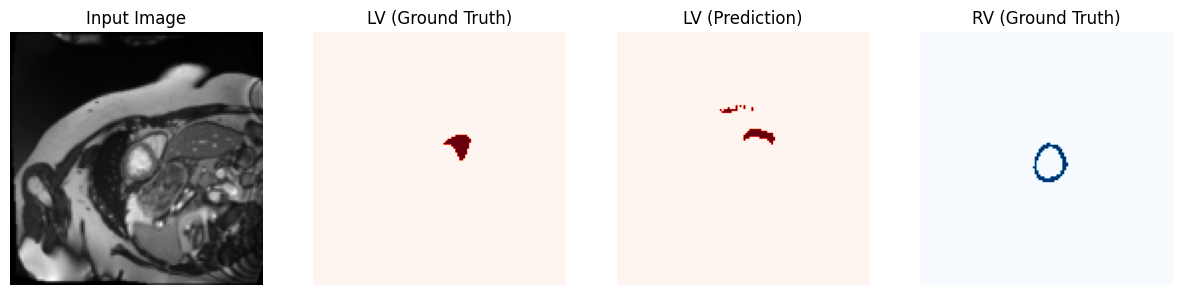

In [94]:
#Step 10 Visualoizing the Predicions 
# Visualize predictions alongside ground truth masks
def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                if count >= num_samples:
                    return

                # Display input image, ground truth, and predicted mask
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 4, 1)
                plt.imshow(images[i, 0].cpu(), cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 4, 2)
                plt.imshow((masks[i] == 1).cpu(), cmap="Reds")
                plt.title("LV (Ground Truth)")
                plt.axis("off")

                plt.subplot(1, 4, 3)
                plt.imshow((preds[i] == 1).cpu(), cmap="Reds")
                plt.title("LV (Prediction)")
                plt.axis("off")

                plt.subplot(1, 4, 4)
                plt.imshow((masks[i] == 2).cpu(), cmap="Blues")
                plt.title("RV (Ground Truth)")
                plt.axis("off")

                plt.show()

                count += 1

# Visualize predictions
visualize_predictions(model, test_loader)


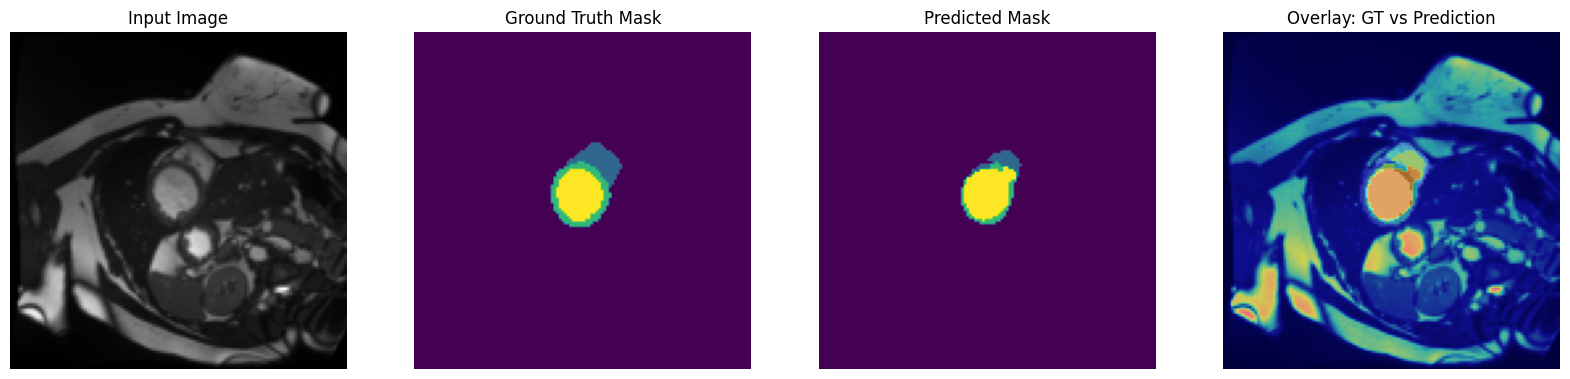

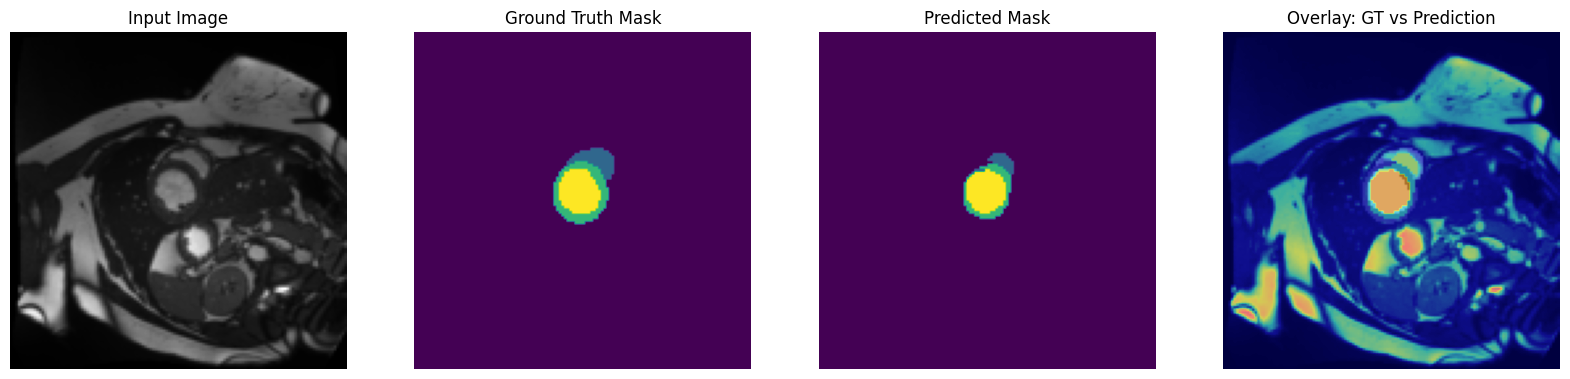

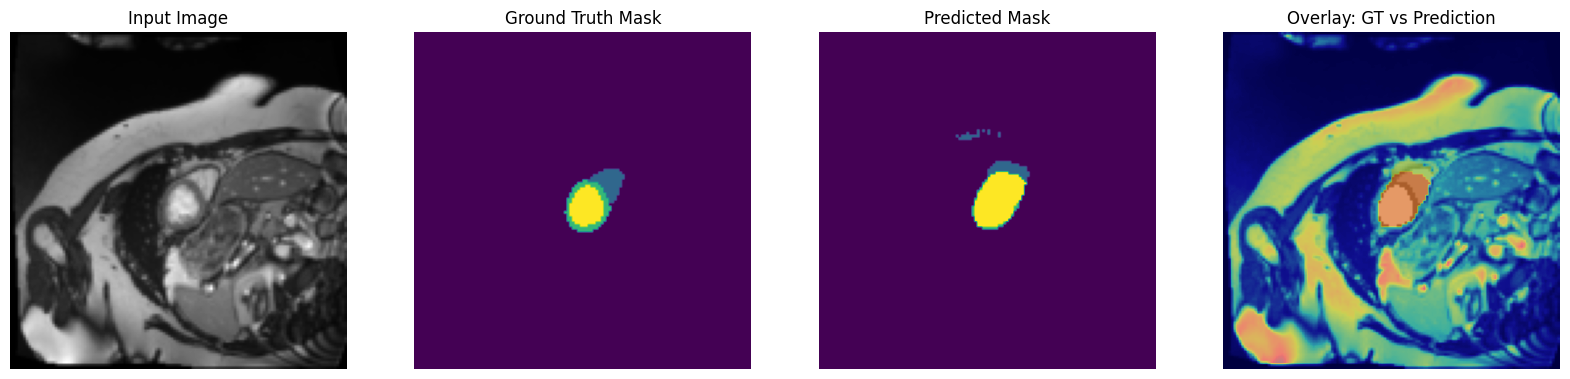

In [95]:
# Step 11  visualize_overall_predictions
def visualize_overall_predictions(model, loader, num_samples=3):
    """
    Visualize the input image, ground truth mask, predicted mask, 
    and an overlay of both the ground truth and prediction.
    """
    model.eval()
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                if count >= num_samples:
                    return
                
                # Create overlay
                ground_truth = masks[i].cpu().numpy()
                prediction = preds[i].cpu().numpy()
                input_image = images[i, 0].cpu().numpy()

                overlay_gt = input_image.copy()
                overlay_pred = input_image.copy()

                overlay_gt[ground_truth == 1] = 0.5  # LV (Ground Truth)
                overlay_gt[ground_truth == 2] = 0.3  # RV (Ground Truth)
                overlay_gt[ground_truth == 3] = 0.7  # Myocardium (Ground Truth)

                overlay_pred[prediction == 1] = 0.5  # LV (Prediction)
                overlay_pred[prediction == 2] = 0.3  # RV (Prediction)
                overlay_pred[prediction == 3] = 0.7  # Myocardium (Prediction)

                # Plot results
                plt.figure(figsize=(20, 5))
                plt.subplot(1, 4, 1)
                plt.imshow(input_image, cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 4, 2)
                plt.imshow(ground_truth, cmap="viridis")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 4, 3)
                plt.imshow(prediction, cmap="viridis")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.subplot(1, 4, 4)
                plt.imshow(overlay_gt, cmap="gray")
                plt.imshow(overlay_pred, cmap="jet", alpha=0.5)
                plt.title("Overlay: GT vs Prediction")
                plt.axis("off")

                plt.show()

                count += 1

# Visualize overall predictions
visualize_overall_predictions(model, test_loader)


In [96]:
# Step 12 Adding Custom Metrics
from scipy.spatial.distance import directed_hausdorff

# Compute Hausdorff Distance
def hausdorff_distance(pred, target):
    pred_points = np.argwhere(pred > 0)
    target_points = np.argwhere(target > 0)
    forward = directed_hausdorff(pred_points, target_points)[0]
    backward = directed_hausdorff(target_points, pred_points)[0]
    return max(forward, backward)

# Compute Class-wise Surface Dice
def surface_dice(pred, target, tolerance=1):
    surface_dice_scores = []
    for cls in range(1, 4):  # LV, RV, Myocardium (ignoring background)
        pred_edges = np.argwhere(pred == cls)
        target_edges = np.argwhere(target == cls)
        close_points = sum(np.any(np.linalg.norm(target_edges - p, axis=1) <= tolerance) for p in pred_edges)
        surface_dice = 2 * close_points / (len(pred_edges) + len(target_edges) + 1e-6)
        surface_dice_scores.append(surface_dice)
    return surface_dice_scores

# Evaluate on the test set
model.eval()
hausdorff_distances = []
surface_dice_scores = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Custom Metrics Evaluation"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        for i in range(len(preds)):
            hausdorff_distances.append([hausdorff_distance(preds[i] == cls, masks[i] == cls) for cls in range(1, 4)])
            surface_dice_scores.append(surface_dice(preds[i], masks[i]))

# Average results
avg_hausdorff = np.mean(hausdorff_distances, axis=0)
avg_surface_dice = np.mean(surface_dice_scores, axis=0)

# Print metrics
for cls, name in enumerate(["LV", "RV", "Myocardium"]):
    print(f"{name} - Hausdorff Distance: {avg_hausdorff[cls]:.4f}, Surface Dice: {avg_surface_dice[cls]:.4f}")


Custom Metrics Evaluation: 100%|██████████| 13/13 [01:58<00:00,  9.12s/it]

LV - Hausdorff Distance: inf, Surface Dice: 0.2827
RV - Hausdorff Distance: 12.4739, Surface Dice: 0.4127
Myocardium - Hausdorff Distance: inf, Surface Dice: 0.6844


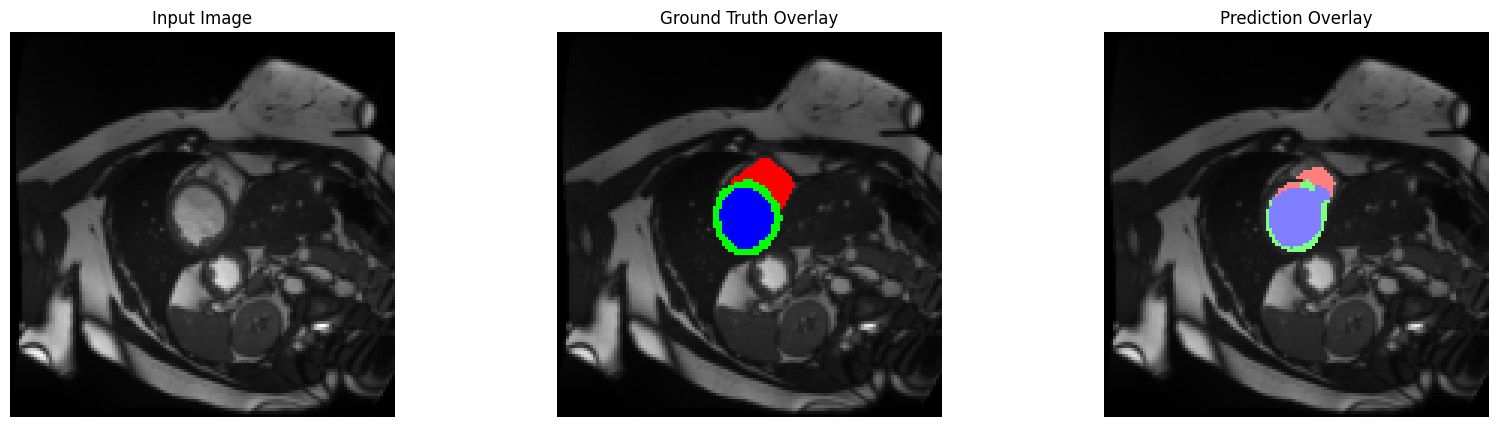

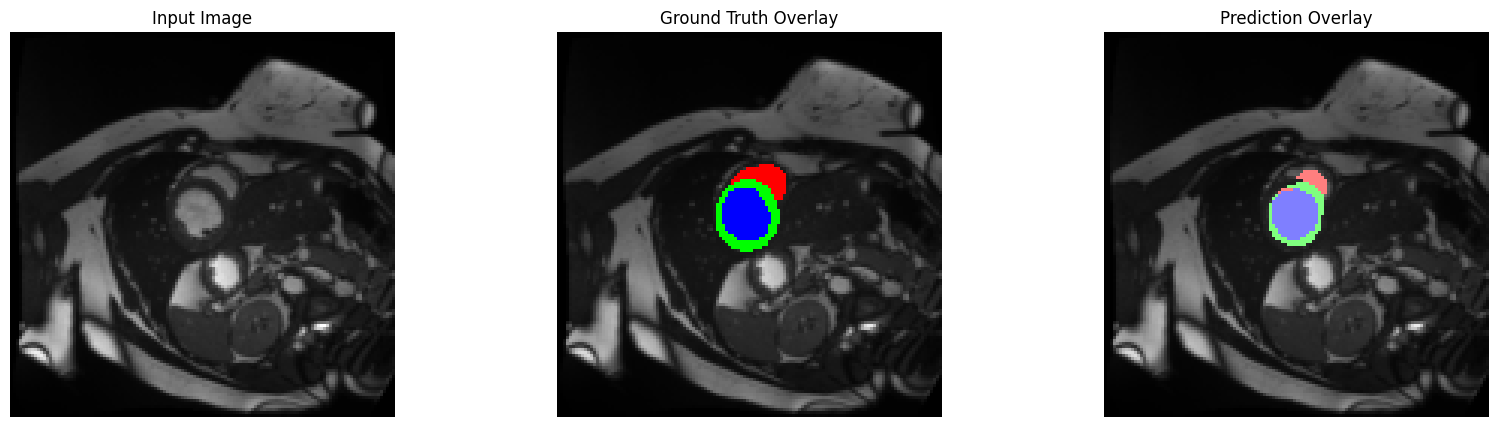

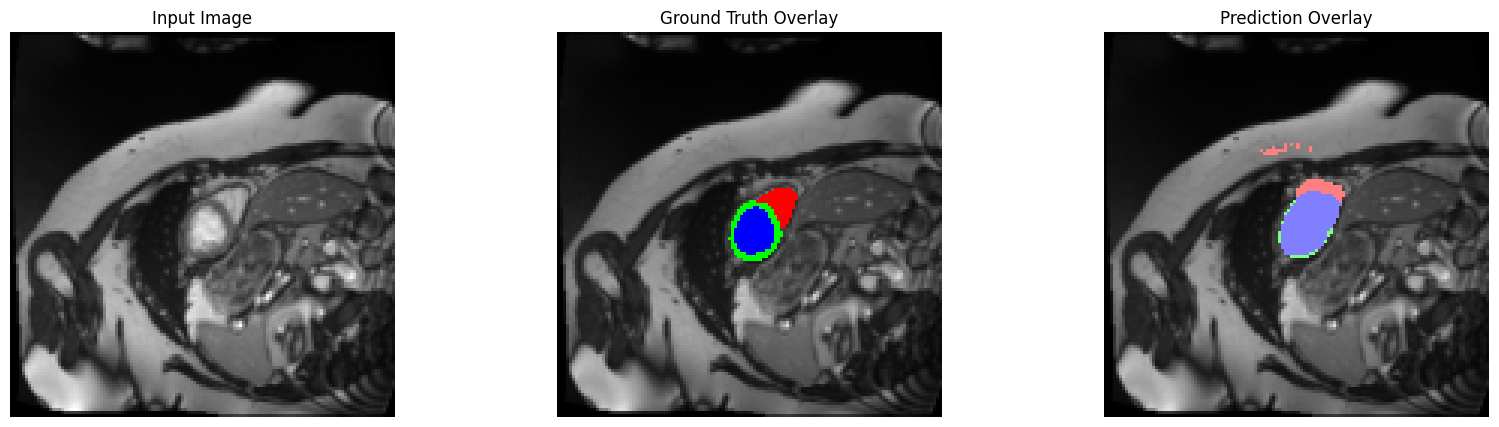

In [97]:
#  Step 13   Improved Visualization with Overlays
def visualize_with_legend(model, loader, num_samples=3):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                if count >= num_samples:
                    return

                # Generate overlays
                input_image = images[i, 0].cpu().numpy()
                ground_truth = masks[i].cpu().numpy()
                prediction = preds[i].cpu().numpy()

                overlay_image = np.stack([input_image] * 3, axis=-1)
                overlay_image[ground_truth == 1] = [1, 0, 0]  # LV (Red)
                overlay_image[ground_truth == 2] = [0, 1, 0]  # RV (Green)
                overlay_image[ground_truth == 3] = [0, 0, 1]  # Myocardium (Blue)

                pred_overlay_image = np.stack([input_image] * 3, axis=-1)
                pred_overlay_image[prediction == 1] = [1, 0.5, 0.5]  # LV (Light Red)
                pred_overlay_image[prediction == 2] = [0.5, 1, 0.5]  # RV (Light Green)
                pred_overlay_image[prediction == 3] = [0.5, 0.5, 1]  # Myocardium (Light Blue)

                # Plot results
                plt.figure(figsize=(20, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(input_image, cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(overlay_image)
                plt.title("Ground Truth Overlay")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_overlay_image)
                plt.title("Prediction Overlay")
                plt.axis("off")

                plt.show()

                count += 1

# Visualize predictions with overlays
visualize_with_legend(model, test_loader)



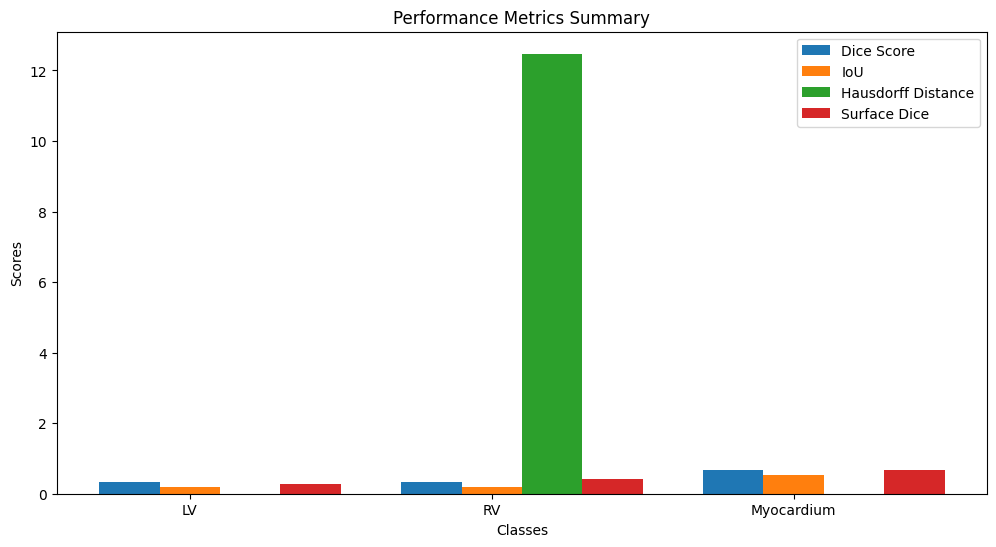

In [98]:
# Step 14 Summarize Performance in a Single Graph
# Metrics summary plot
def plot_metrics_summary(avg_metrics, avg_hausdorff, avg_surface_dice):
    classes = ["LV", "RV", "Myocardium"]

    # Metrics
    dice_scores = avg_metrics["F1-Score"][1:]  # Ignore background
    iou_scores = avg_metrics["IoU"][1:]
    hausdorff_scores = avg_hausdorff
    surface_dice_scores = avg_surface_dice

    x = np.arange(len(classes))

    plt.figure(figsize=(12, 6))
    bar_width = 0.2

    plt.bar(x - bar_width, dice_scores, bar_width, label="Dice Score")
    plt.bar(x, iou_scores, bar_width, label="IoU")
    plt.bar(x + bar_width, hausdorff_scores, bar_width, label="Hausdorff Distance")
    plt.bar(x + 2 * bar_width, surface_dice_scores, bar_width, label="Surface Dice")

    plt.xlabel("Classes")
    plt.ylabel("Scores")
    plt.title("Performance Metrics Summary")
    plt.xticks(x, classes)
    plt.legend()
    plt.show()

# Plot metrics summary
plot_metrics_summary(avg_metrics, avg_hausdorff, avg_surface_dice)



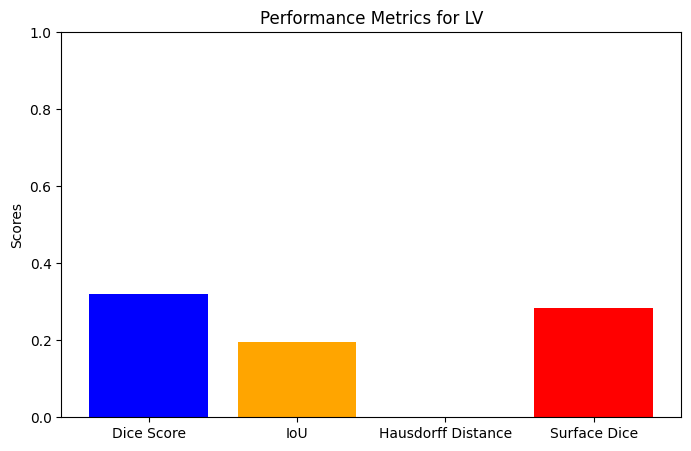

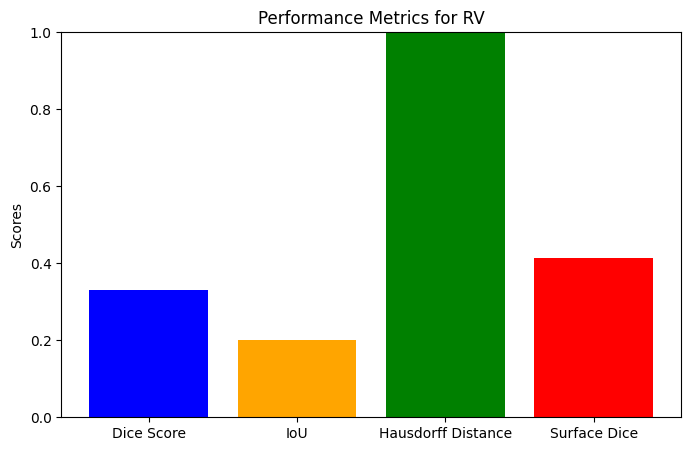

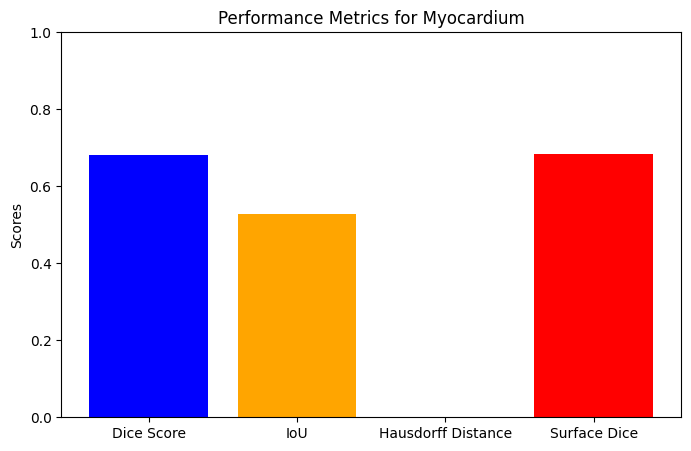

In [99]:
# Step 15 plot_classwise_metrics
def plot_classwise_metrics(avg_metrics, avg_hausdorff, avg_surface_dice):
    classes = ["LV", "RV", "Myocardium"]
    metrics = ["Dice Score", "IoU", "Hausdorff Distance", "Surface Dice"]
    
    # Metrics
    dice_scores = avg_metrics["F1-Score"][1:]  # Ignore background
    iou_scores = avg_metrics["IoU"][1:]
    hausdorff_scores = avg_hausdorff
    surface_dice_scores = avg_surface_dice

    class_metrics = {
        "Dice Score": dice_scores,
        "IoU": iou_scores,
        "Hausdorff Distance": hausdorff_scores,
        "Surface Dice": surface_dice_scores,
    }

    # Plot separate graphs for each class
    for i, cls in enumerate(classes):
        plt.figure(figsize=(8, 5))
        plt.bar(metrics, [class_metrics[m][i] for m in metrics], color=["blue", "orange", "green", "red"])
        plt.title(f"Performance Metrics for {cls}")
        plt.ylabel("Scores")
        plt.ylim(0, 1)  # Set consistent y-axis range for better comparison
        plt.show()

# Call the function to plot class-wise metrics
plot_classwise_metrics(avg_metrics, avg_hausdorff, avg_surface_dice)


In [101]:
# Step 16 Track IoU During Training
# Function to calculate IoU
def calculate_iou(pred, target, num_classes=4, epsilon=1e-6):
    pred_one_hot = F.one_hot(pred, num_classes=num_classes).permute(0, 3, 1, 2)
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2)

    iou_scores = []
    for cls in range(num_classes):
        intersection = (pred_one_hot[:, cls] * target_one_hot[:, cls]).sum()
        union = pred_one_hot[:, cls].sum() + target_one_hot[:, cls].sum() - intersection
        iou = (intersection + epsilon) / (union + epsilon)
        iou_scores.append(iou.item())
    return iou_scores

# Updated training loop with IoU tracking
iou_history = {"LV": [], "RV": [], "Myocardium": []}

for epoch in range(epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    epoch_iou = np.zeros(3)  # IoU for LV, RV, Myocardium
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            iou_scores = calculate_iou(preds, masks)
            epoch_iou += np.array(iou_scores[1:])  # Skip background

    # Average IoU over validation batches
    epoch_iou /= len(val_loader)
    iou_history["LV"].append(epoch_iou[0])
    iou_history["RV"].append(epoch_iou[1])
    iou_history["Myocardium"].append(epoch_iou[2])

    print(f"Epoch {epoch + 1}: IoU - LV: {epoch_iou[0]:.4f}, RV: {epoch_iou[1]:.4f}, Myocardium: {epoch_iou[2]:.4f}")


Epoch 1: IoU - LV: 0.2507, RV: 0.2578, Myocardium: 0.5252
Epoch 2: IoU - LV: 0.2194, RV: 0.3024, Myocardium: 0.5396
Epoch 3: IoU - LV: 0.2921, RV: 0.3010, Myocardium: 0.5485
Epoch 4: IoU - LV: 0.2623, RV: 0.3434, Myocardium: 0.5530
Epoch 5: IoU - LV: 0.3152, RV: 0.3770, Myocardium: 0.5629
Epoch 6: IoU - LV: 0.3565, RV: 0.3576, Myocardium: 0.5762
Epoch 7: IoU - LV: 0.3855, RV: 0.3047, Myocardium: 0.5761
Epoch 8: IoU - LV: 0.3840, RV: 0.4048, Myocardium: 0.6052
Epoch 9: IoU - LV: 0.3998, RV: 0.3949, Myocardium: 0.6167
Epoch 10: IoU - LV: 0.4367, RV: 0.4340, Myocardium: 0.6596
Epoch 11: IoU - LV: 0.4251, RV: 0.3738, Myocardium: 0.6458
Epoch 12: IoU - LV: 0.4539, RV: 0.3906, Myocardium: 0.6190
Epoch 13: IoU - LV: 0.4648, RV: 0.3974, Myocardium: 0.6815
Epoch 14: IoU - LV: 0.4654, RV: 0.4607, Myocardium: 0.6926
Epoch 15: IoU - LV: 0.3491, RV: 0.3515, Myocardium: 0.5685
Epoch 16: IoU - LV: 0.4653, RV: 0.4164, Myocardium: 0.6386
Epoch 17: IoU - LV: 0.4625, RV: 0.4133, Myocardium: 0.6802
Epoch 

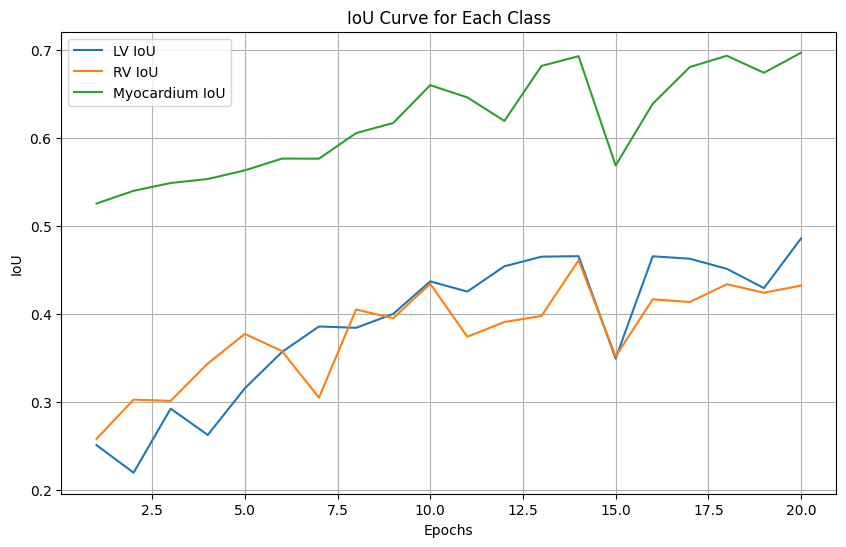

In [102]:
# Step 17
# Plot IoU curves
def plot_iou_curves(iou_history):
    epochs = range(1, len(iou_history["LV"]) + 1)

    plt.figure(figsize=(10, 6))
    for cls, iou_scores in iou_history.items():
        plt.plot(epochs, iou_scores, label=f"{cls} IoU")

    plt.title("IoU Curve for Each Class")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot IoU curves
plot_iou_curves(iou_history)


Validation: 100%|██████████| 13/13 [01:16<00:00,  5.86s/it]


Epoch 1: IoU - LV: 0.4390, RV: 0.3930, Myocardium: 0.6514


Validation: 100%|██████████| 13/13 [01:16<00:00,  5.85s/it]


Epoch 2: IoU - LV: 0.3927, RV: 0.3363, Myocardium: 0.5178


Validation: 100%|██████████| 13/13 [01:16<00:00,  5.88s/it]


Epoch 3: IoU - LV: 0.5011, RV: 0.4542, Myocardium: 0.7213


Validation: 100%|██████████| 13/13 [01:16<00:00,  5.91s/it]


Epoch 4: IoU - LV: 0.4017, RV: 0.3571, Myocardium: 0.5947


Validation: 100%|██████████| 13/13 [01:17<00:00,  5.94s/it]


Epoch 5: IoU - LV: 0.4925, RV: 0.4569, Myocardium: 0.6925


Validation: 100%|██████████| 13/13 [01:15<00:00,  5.84s/it]


Epoch 6: IoU - LV: 0.4578, RV: 0.4187, Myocardium: 0.6511


Validation: 100%|██████████| 13/13 [01:16<00:00,  5.87s/it]


Epoch 7: IoU - LV: 0.4769, RV: 0.4342, Myocardium: 0.6636


Validation: 100%|██████████| 13/13 [01:17<00:00,  5.94s/it]


Epoch 8: IoU - LV: 0.5063, RV: 0.4415, Myocardium: 0.6818


Validation: 100%|██████████| 13/13 [01:13<00:00,  5.69s/it]


Epoch 9: IoU - LV: 0.4895, RV: 0.4335, Myocardium: 0.6800


Validation: 100%|██████████| 13/13 [01:21<00:00,  6.24s/it]


Epoch 10: IoU - LV: 0.4791, RV: 0.4244, Myocardium: 0.7000


Validation: 100%|██████████| 13/13 [01:14<00:00,  5.76s/it]


Epoch 11: IoU - LV: 0.4953, RV: 0.4170, Myocardium: 0.7022


Validation: 100%|██████████| 13/13 [01:27<00:00,  6.75s/it]


Epoch 12: IoU - LV: 0.5036, RV: 0.4198, Myocardium: 0.6887


Validation: 100%|██████████| 13/13 [01:24<00:00,  6.53s/it]


Epoch 13: IoU - LV: 0.4626, RV: 0.4077, Myocardium: 0.6403


Validation: 100%|██████████| 13/13 [01:18<00:00,  6.04s/it]


Epoch 14: IoU - LV: 0.4884, RV: 0.4204, Myocardium: 0.6698


Validation: 100%|██████████| 13/13 [01:12<00:00,  5.60s/it]


Epoch 15: IoU - LV: 0.4899, RV: 0.4061, Myocardium: 0.6711


Validation: 100%|██████████| 13/13 [01:13<00:00,  5.63s/it]


Epoch 16: IoU - LV: 0.5051, RV: 0.4420, Myocardium: 0.6913


Validation: 100%|██████████| 13/13 [01:12<00:00,  5.59s/it]


Epoch 17: IoU - LV: 0.4975, RV: 0.4441, Myocardium: 0.6974


Validation: 100%|██████████| 13/13 [01:13<00:00,  5.64s/it]


Epoch 18: IoU - LV: 0.5098, RV: 0.4414, Myocardium: 0.7150


Validation: 100%|██████████| 13/13 [02:55<00:00, 13.51s/it]


Epoch 19: IoU - LV: 0.4771, RV: 0.4078, Myocardium: 0.6799


Validation: 100%|██████████| 13/13 [01:14<00:00,  5.75s/it]


Epoch 20: IoU - LV: 0.5102, RV: 0.4344, Myocardium: 0.7124


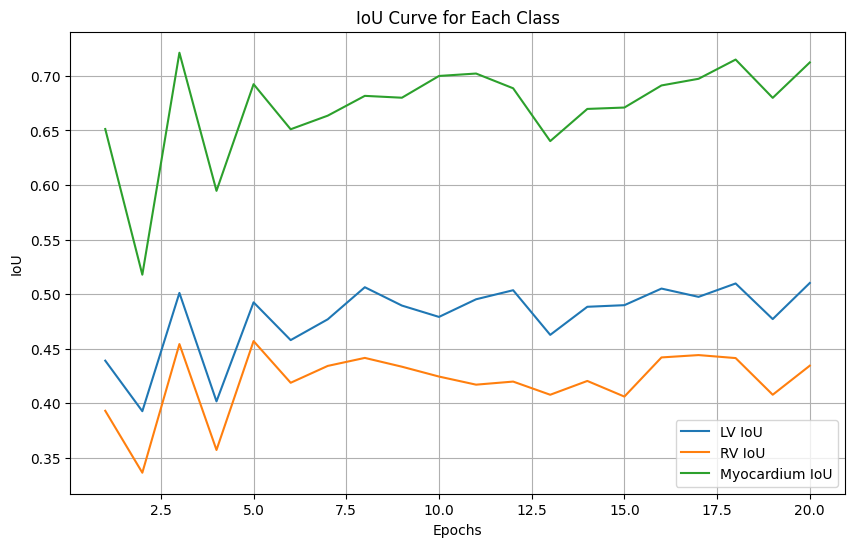

In [103]:
# Step 18  Integrated Code for IoU Tracking, History, and Curve Plotting
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Function to calculate IoU for each class
def calculate_iou(pred, target, num_classes=4, epsilon=1e-6):
    pred_one_hot = F.one_hot(pred, num_classes=num_classes).permute(0, 3, 1, 2)
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2)

    iou_scores = []
    for cls in range(num_classes):
        intersection = (pred_one_hot[:, cls] * target_one_hot[:, cls]).sum()
        union = pred_one_hot[:, cls].sum() + target_one_hot[:, cls].sum() - intersection
        iou = (intersection + epsilon) / (union + epsilon)
        iou_scores.append(iou.item())
    return iou_scores

# Training loop with IoU tracking
iou_history = {"LV": [], "RV": [], "Myocardium": []}  # For storing IoU scores
epochs = 20  # Define the number of epochs

for epoch in range(epochs):
    model.train()
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    epoch_iou = np.zeros(3)  # IoU for LV, RV, Myocardium
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            iou_scores = calculate_iou(preds, masks)
            epoch_iou += np.array(iou_scores[1:])  # Skip background class

    # Average IoU over validation batches
    epoch_iou /= len(val_loader)
    iou_history["LV"].append(epoch_iou[0])
    iou_history["RV"].append(epoch_iou[1])
    iou_history["Myocardium"].append(epoch_iou[2])

    print(f"Epoch {epoch + 1}: IoU - LV: {epoch_iou[0]:.4f}, RV: {epoch_iou[1]:.4f}, Myocardium: {epoch_iou[2]:.4f}")

# Plot IoU curves
def plot_iou_curves(iou_history):
    epochs = range(1, len(iou_history["LV"]) + 1)

    plt.figure(figsize=(10, 6))
    for cls, iou_scores in iou_history.items():
        plt.plot(epochs, iou_scores, label=f"{cls} IoU")

    plt.title("IoU Curve for Each Class")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot IoU curves
plot_iou_curves(iou_history)


In [104]:
# Step 19
# Function to calculate accuracy
def calculate_accuracy(pred, target, num_classes=4):
    """
    Computes class-wise accuracy and overall accuracy.
    Args:
        pred: Predicted mask (B, H, W)
        target: Ground truth mask (B, H, W)
        num_classes: Number of classes (including background)
    Returns:
        class_accuracies: List of class-wise accuracies
        overall_accuracy: Overall accuracy
    """
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for cls in range(num_classes):
        class_correct[cls] += ((pred == cls) & (target == cls)).sum().item()
        class_total[cls] += (target == cls).sum().item()

    class_accuracies = class_correct / (class_total + 1e-6)
    overall_accuracy = class_correct.sum() / class_total.sum()

    return class_accuracies, overall_accuracy

# Evaluate model on test set for accuracy
model.eval()
all_class_accuracies = []
all_overall_accuracies = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing for Accuracy"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        # Calculate accuracies for the batch
        class_accuracies, overall_accuracy = calculate_accuracy(preds.cpu(), masks.cpu())
        all_class_accuracies.append(class_accuracies)
        all_overall_accuracies.append(overall_accuracy)

# Average accuracies over all batches
avg_class_accuracies = np.mean(all_class_accuracies, axis=0)
avg_overall_accuracy = np.mean(all_overall_accuracies)

# Print class-wise and overall accuracy
classes = ["Background", "LV", "RV", "Myocardium"]
for i, cls in enumerate(classes):
    print(f"Accuracy for {cls}: {avg_class_accuracies[i] * 100:.2f}%")
print(f"Overall Accuracy: {avg_overall_accuracy * 100:.2f}%")


Testing for Accuracy: 100%|██████████| 13/13 [01:17<00:00,  6.00s/it]

Accuracy for Background: 99.56%
Accuracy for LV: 65.49%
Accuracy for RV: 56.43%
Accuracy for Myocardium: 81.22%
Overall Accuracy: 98.17%
